In [164]:
import pandas as pd
import errno    
import os
import numpy as np
import math
import pickle
import time

'''
Author: Enrico Ceccolini
    Correspond to an offline power prediction model to be used to predict the mean 
    power consumption, over the execution interval, of a job submitted on the Erurora HPC. 
'''

datadir = "/datasets/eurora_data/db1/"
datadir = "/datasets/eurora_data/db/" #hdd

infile_jobs_to_nodes = datadir + "job_nodes.csv"

suffix = "_5sec_"
### select an interval from
## 1 settings wholeData
#interval_comment_whole = "WholeData"

### select an interval from


## 2 settings Andrea
interval_comment = "Andrea"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')
infile_jobs = datadir + "april_long_jobs.csv"

## 3 settings Alina
#interval_comment = "Alina"
#start_time = pd.to_datetime('2014-03-31')
#end_time = pd.to_datetime('2014-11-01')
#train_start_time = pd.to_datetime('2014-03-31')
#train_end_time = pd.to_datetime('2014-10-01')
#test_end_time = pd.to_datetime('2014-11-01')

infile_jobs_trainset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_trainset"
infile_jobs_testset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset"
infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole"

infile_jobs_trainset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_trainset_clear"
infile_jobs_testset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset_clear"
infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_clear"

#outfile_testset_pred = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset_pred"
#
infile_jobs_trainset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_trainset_random"
infile_jobs_testset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset_random"
outfile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_random"
infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_random"
outfile_user_job_node_dict = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_random"


nodes=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']

In [165]:
jobs_train = pd.read_csv(infile_jobs_trainset + ".csv", index_col=0)
print("train set contains {} records".format(jobs_train.shape[0]))
jobs_test = pd.read_csv(infile_jobs_testset + ".csv", index_col=0)
print("test set contains {} records".format(jobs_test.shape[0]))

train set contains 10000 records
test set contains 768 records


In [166]:
jobs_to_nodes_whole_data = pd.read_csv(infile_jobs_to_nodes, index_col=0)
print("jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))
### clean the data
# remove jobs runned on the inexistent node 129
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data[jobs_to_nodes_whole_data['node_id'] != 129] 
# remove jobs with the same id that runned on the same node
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data.drop_duplicates(subset=['job_id_string', 'node_id'])
print("after the clean, jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

jobs_to_nodes_whole_data contains 469095 records
after the clean, jobs_to_nodes_whole_data contains 444610 records


In [167]:
### merge the info from the two tables
merged_jobs_to_nodes = pd.merge(jobs_test, jobs_to_nodes_whole_data, how='left', on='job_id_string')
print("merged_jobs_to_nodes contains {} records".format(merged_jobs_to_nodes.shape[0]))

merged_jobs_to_nodes contains 881 records


In [168]:
grouped_jobs_test = merged_jobs_to_nodes.groupby(['user', 'job_name', 'node_id']).size().reset_index(name='counts')

print("{}/{} distinct execution".format(grouped_jobs_test.shape[0], merged_jobs_to_nodes.shape[0]))

548/881 distinct execution


In [169]:
grouped_jobs_test = jobs_test.groupby(['user', 'job_name']).size().reset_index(name='counts')
print("{}/{} distinct job names".format(grouped_jobs_test.shape[0], merged_jobs_to_nodes.shape[0]))

153/881 distinct job names


In [170]:
# ---- whole dictionary



with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)

In [171]:
dict_user_job_node_copy = dict(dict_user_job_node)

In [172]:
#dict_user_job_node

In [173]:
def validate_predictions_2(y_values, predictions):
    mean_real_pow = y_values.mean()
    #print("the mean is {}".format(mean_real_pow))

    eq_num = (y_values - predictions)**2
    eq_den = (y_values - mean_real_pow)**2
    N = eq_num.shape[0]

    r_2 = 1 - (eq_num.sum() / eq_den.sum())
    print("r_2 is {}".format(r_2))

    rmse = math.sqrt(eq_num.sum() / N)
    #print("RMSE is {}".format(rmse))
    print("NRMSE is {}".format(rmse/mean_real_pow))
    
    prediction_error = np.abs(predictions - y_values) / predictions
    clean_prediction = prediction_error[~np.isnan(prediction_error)]
    print("prediction error is {}".format(np.average(clean_prediction)))
    print("{}/{}".format(clean_prediction.shape[0], prediction_error.shape[0]))
    
    return r_2
    

In [174]:
''' 1 dictionary
Predict the power consumption of a job.
    If the user and the job name are known, than it use the method 1 [user,job,nodes]
    if only the user is known, than it use the method 2 [user,nodes]
    Otherwise it use the method 3 [nodes]
'''

def predict_pow_treshold_dict(user, job_name, used_nodes, used_cpus, treshold_5=1, treshold_4=1, treshold_3=0, treshold_2=0):
    pred_pow = 0.0
    
    methods = [0, 0, 0, 0, 0]  
    
    d_nodes = dict_user_job_node['node_avg']
    
    if(user in dict_user_job_node):
        d_user = dict_user_job_node[user]
        
        if(job_name in d_user):
            d_user_job = d_user[job_name]
            for node_id, ncpu in zip(used_nodes, used_cpus):
                if(node_id in d_user_job and d_user_job[node_id][1] > treshold_5): # method 5 - user - job - node
                    pred_pow += d_user_job[node_id][0] * ncpu
                    methods[0] += 1
                elif(d_user_job['user_job_avg'][1] > treshold_4): #  method 4 - user - job
                    pred_pow += d_user_job['user_job_avg'][0] * ncpu
                    methods[1] += 1
                elif(node_id in d_user['user_node_avg'] and d_user['user_node_avg'][node_id][1] > treshold_3): # method 3 - user - node
                    pred_pow += d_user['user_node_avg'][node_id][0] * ncpu
                    methods[2] += 1
                elif(d_user['user_avg'][1] > treshold_2): # method 2 - user
                    pred_pow += d_user['user_avg'][0] * ncpu
                    methods[3] += 1
                else: # method 1 - node
                    pred_pow += d_nodes[node_id][0] * ncpu
                    methods[4] += 1
                    
        else: # NON ho il job         
            for node_id, ncpu in zip(used_nodes, used_cpus):
                if(node_id in d_user['user_node_avg'] and d_user['user_node_avg'][node_id][1] > treshold_3): # method 3 - user - node
                    pred_pow += d_user['user_node_avg'][node_id][0] * ncpu
                    methods[2] += 1
                elif(d_user['user_avg'][1] > treshold_2): # method 2 - user
                    pred_pow += d_user['user_avg'][0] * ncpu
                    methods[3] += 1
                else: # method 1 - node
                    pred_pow += d_nodes[node_id][0] * ncpu
                    methods[4] += 1

    else:  # method 1 - node
        #d_nodes = dict_user_job_node['node_avg']
        for node_id, ncpu in zip(used_nodes, used_cpus):
            pred_pow += d_nodes[node_id][0] * ncpu
            methods[4] += 1
    
    return (methods, pred_pow)

In [175]:
import matplotlib.pyplot as plt

def my_scatter_plot(x_values, y_values, xy_min, xy_lim, mark_s=100, title=""):

    #fig, = plt.figure(figsize=(9, 9))  
    
    fig, ax = plt.subplots(figsize=(20, 8))
    
    x1 = [0, xy_lim]
    y1 = [0, xy_lim]
    ax.plot(x1, y1, 'gray', linestyle=':', marker='')
    
    plt.xlabel('real pow (w)', fontsize=18)
    plt.ylabel('predicted pow (w)', fontsize=18)
    plt.title(title, fontsize=20)
    
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    plt.xlim(xy_min, xy_lim)
    plt.ylim(xy_min, xy_lim)
    #plt.gca().set_aspect('equal', adjustable='box')
    
    #visualize results
    plt.scatter(x_values, y_values, marker='x', s=mark_s)
    plt.plot()

    plt.show()

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.pyplot import figure
#plt.rcParams['figure.figsize'] = (15,8)

def plotPredError(differences, nbins=1000, min_x=-1000, max_x=1000, max_y=6000):

    fig, ax = plt.subplots(figsize=(15, 8))
    #num_bins = 3000
    n, bins, patches = plt.hist(differences, bins = nbins, facecolor='blue', alpha=1)
    #plt.axis([-0.25, 0.25, 0, 3000])
    plt.axis([min_x, max_x, 0, max_y])
    plt.xlabel("prediction error (w)", fontsize=18)
    plt.ylabel("data points", fontsize=18)

    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    plt.show()

In [177]:
import matplotlib.pyplot as plt

def my_scatter_plot_small(x_values, y_values, xy_min, xy_lim, mark_s=100, title=""):

    #fig, = plt.figure(figsize=(9, 9))  
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    x1 = [0, xy_lim]
    y1 = [0, xy_lim]
    ax.plot(x1, y1, 'gray', linestyle=':', marker='')
    
    plt.xlabel('real pow (w)', fontsize=18)
    plt.ylabel('predicted pow (w)', fontsize=18)
    plt.title(title, fontsize=20)
    
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    plt.xlim(xy_min, xy_lim)
    plt.ylim(xy_min, xy_lim)
    #plt.gca().set_aspect('equal', adjustable='box')
    
    #visualize results
    plt.scatter(x_values, y_values, marker='x', s=mark_s)
    plt.plot()

    plt.show()

In [178]:
jobs_test.columns

Index(['job_id_string', 'job_name', 'queue', 'start_time', 'run_start_time',
       'end_time', 'user', 'node_req', 'cpu_req', 'mem_req', 'time_req',
       'deleted', 'dependency', 'exit_status', 'pbs_exit_code', 'gpu_req',
       'mic_req', 'real_pow', 'ran_alone', 'real_pow_quality', 'n_2_1',
       'n_2_2', 'n_3_1', 'job_tot_timepoints', 'job_timepoints', 'good_nodes',
       'ncores_system', 'njobs_system', 'load_system'],
      dtype='object')

In [179]:
df_jobs_to_test = jobs_test

In [180]:
start_time = time.time()

# select jobs to test and create the list
# set as job_test if you want to make a complete test on the test_set

#df_jobs_to_test = jobs_test.head(1000)

#df_jobs_to_test = jobs_test # test on whole testset
list_jobs_to_test = []

for index_job_test, row_job_test in df_jobs_to_test.iterrows():
    
    merged_job_to_nodes = merged_jobs_to_nodes[merged_jobs_to_nodes['job_id_string'] == row_job_test['job_id_string']]
    grouped_job_to_nodes = merged_job_to_nodes.groupby(['node_id', 'ncpus','ngpus', 'nmics']).size().reset_index(name='counts')
    
    used_nodes = grouped_job_to_nodes['node_id'].tolist()
    used_cpus = grouped_job_to_nodes['ncpus'].tolist()
    
    list_jobs_to_test.append([row_job_test['user'], row_job_test['job_name'], used_nodes, used_cpus, row_job_test['real_pow']])
    

list_jobs_to_test_bk = list_jobs_to_test
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.445626974105835 seconds ---


In [181]:
#jobs_test

### compare 5 methods

In [208]:
with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)
jobs_predictions = []
global_methods_online = [0, 0, 0, 0, 0]

for job in list_jobs_to_test:
    methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
        #used_cpus=job[3], treshold_5=0, treshold_4=0, treshold_3=0, treshold_2=0)
        used_cpus=job[3], treshold_5=0, treshold_4=0, treshold_3=100, treshold_2=100)
    
    if True:
        for j in range(5):
            global_methods_online[j] += methods[j]
    
    jobs_predictions.append(predicted_pow)
    
print(global_methods_online)
# print(sum(global_methods_online))

validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)


[683, 139, 0, 16, 43]
r_2 is 0.6759103812819962
NRMSE is 0.4078195876724314
prediction error is 0.2782224464715051
768/768


0.6759103812819962

In [183]:
df_jobs_to_test[df_jobs_to_test['real_pow']<1].shape

(0, 29)

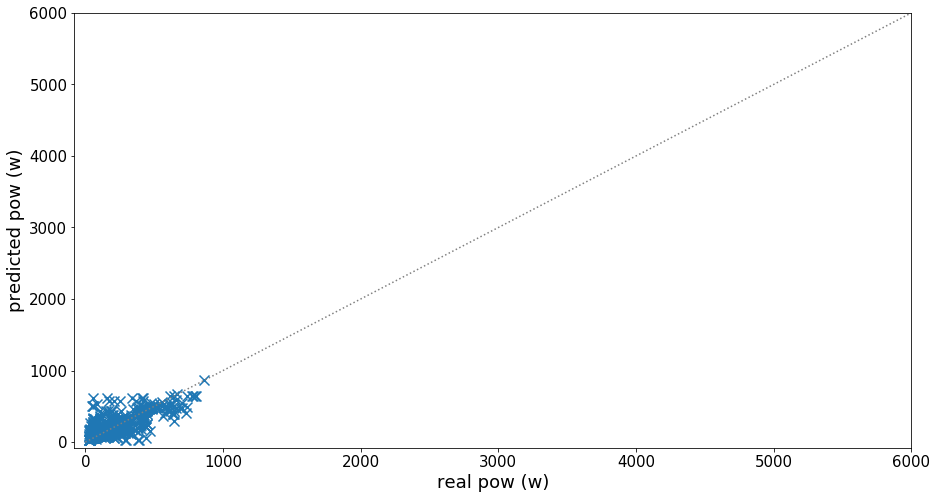

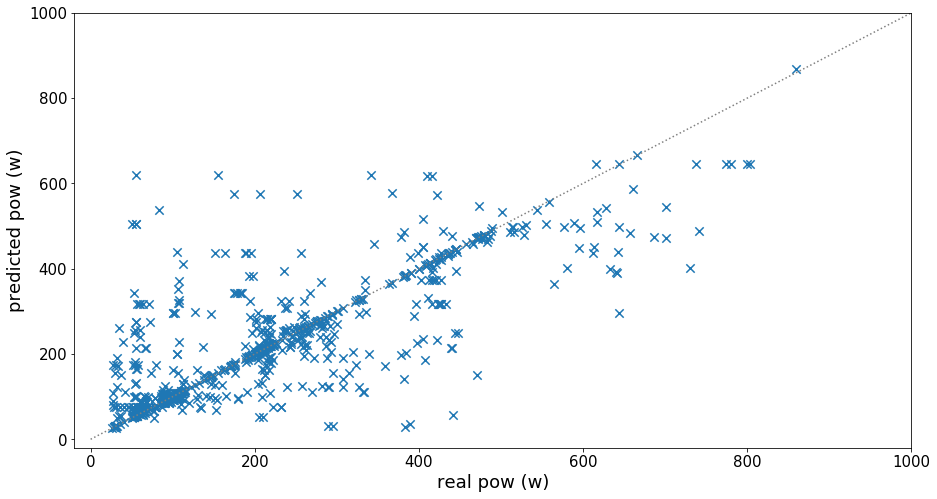

In [184]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown
my_scatter_plot_small(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=6000)
my_scatter_plot_small(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

r_2 is 0.7969332324607477
NRMSE is 0.945973814033381
prediction error is 0.5709589534633762
768/768


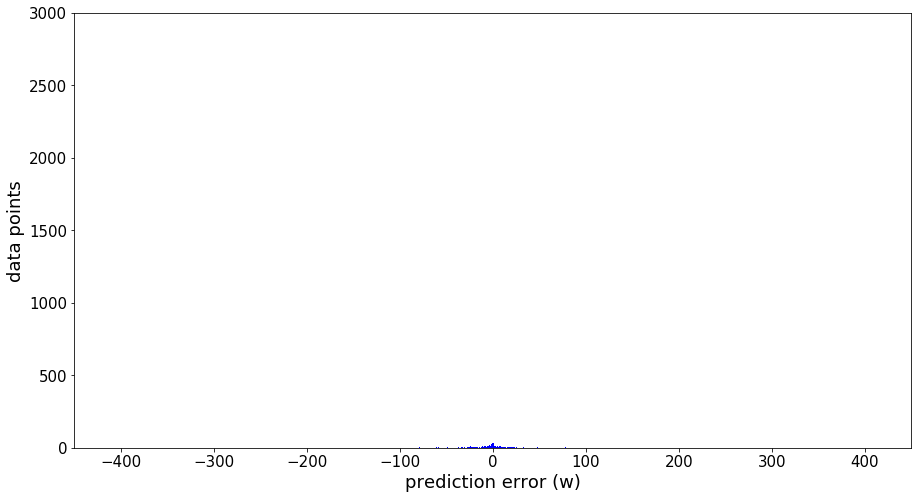

In [155]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
#df = pd.DataFrame(differences)
#df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['real_pow']
plotPredError(differences, nbins=2000, min_x=-450, max_x=450, max_y=3000)

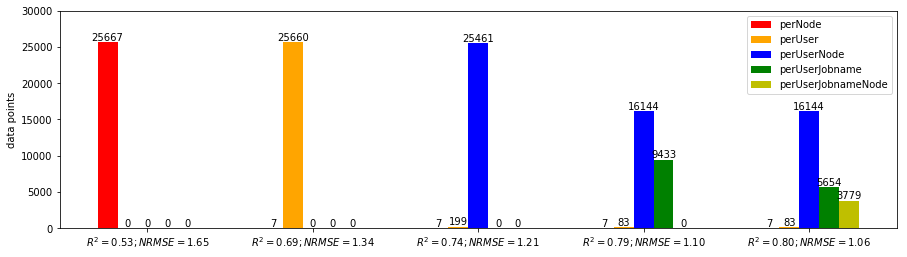

In [85]:
x = [[],
     [],
     [],
     [],
     []]

"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = 5
#offline
m1 = (0, 0, 0, 0, 3779)
m2 = (0, 0, 0, 9433, 5654)
m3 = (0, 0, 25461, 16144, 16144)
m4 = (0, 25660, 199, 83, 83)
m5 = (25667, 7, 7, 7, 7)


ind = np.arange(N)  # the x locations for the groups
width = 0.12      # the width of the bars

fig, ax = plt.subplots(figsize=(15, 4))
rects1 = ax.bar(ind, m5, width, color='r')
rects2 = ax.bar(ind+width, m4, width, color='orange')
rects3 = ax.bar(ind+width*2, m3, width, color='b')
rects4 = ax.bar(ind+width*3, m2, width, color='g')
rects5 = ax.bar(ind+width*4, m1, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('data points')
ax.set_title('')
ax.set_xticks(ind + 2*width)
#ax.set_xticklabels(('$R^2=0.44; NRMSE=1.60$', '$R^2=0.59; NRMSE=1.37$', '$R^2=0.64; NRMSE=1.28$', '$R^2=0.68; NRMSE=1.20$', '$R^2=0.69; NRMSE=1.18$'))
ax.set_xticklabels(('$R^2=0.53; NRMSE=1.65$', '$R^2=0.69; NRMSE=1.34$', '$R^2=0.74; NRMSE=1.21$', '$R^2=0.79; NRMSE=1.10$', '$R^2=0.80; NRMSE=1.06$'))
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,30000])

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), 
('perNode', 'perUser', 'perUserNode', 'perUserJobname', 'perUserJobnameNode'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

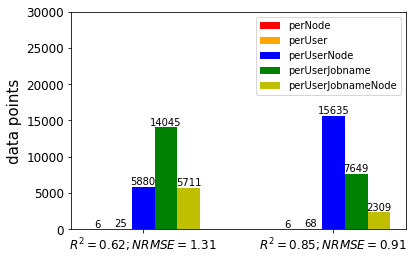

In [107]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
#online
m1 = (5711, 2309)
m2 = (14045, 7649)
m3 = (5880, 15635)
m4 = (25, 68)
m5 = (6, 6)


ind = np.arange(N)  # the x locations for the groups
width = 0.12      # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(ind, m5, width, color='r')
rects2 = ax.bar(ind+width, m4, width, color='orange')
rects3 = ax.bar(ind+width*2, m3, width, color='b')
rects4 = ax.bar(ind+width*3, m2, width, color='g')
rects5 = ax.bar(ind+width*4, m1, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('data points')
ax.set_title('')
ax.set_xticks(ind + 2*width)
ax.set_xticklabels(('$R^2=0.62; NRMSE=1.31$', '$R^2=0.85; NRMSE=0.91$'))
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,30000])

plt.ylabel('data points', fontsize=15)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), 
('perNode', 'perUser', 'perUserNode', 'perUserJobname', 'perUserJobnameNode'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

#r_2 is 0.855607833633744
#NRMSE is 0.8173757541715595

### Offline

In [156]:
# predict offline misuring the time

# ---- whole dictionary
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole"
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_clear"
#
#with open(infile_user_job_node + ".pkl", 'rb') as handle:
#    dict_user_job_node = pickle.load(handle)
with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)
jobs_predictions = []
global_methods_online = [0, 0, 0, 0, 0]

start_time = time.time()

for job in list_jobs_to_test:
    #methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
    #    used_cpus=job[3], treshold_5=1, treshold_4=5, treshold_3=1, treshold_2=12)
    #methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
     #   used_cpus=job[3], treshold_5=4, treshold_4=6, treshold_3=2, treshold_2=8)
    methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
        used_cpus=job[3], treshold_5=4, treshold_4=4, treshold_3=4, treshold_2=0)
    
    if True:
        for j in range(5):
            global_methods_online[j] += methods[j]
    
    jobs_predictions.append(predicted_pow)
    
print("--- %s seconds ---" % (time.time() - start_time))
print(global_methods_online)
print(sum(global_methods_online))

#print(df_jobs_to_test['real_pow'])
#print([(lambda x: print(x))(x) for x in jobs_predictions])
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

#--- 0.08289122581481934 seconds ---
#[0, 0, 0, 0, 0]
#0
#r_2 is 0.7666871168925228
#NRMSE is 1.1430627928001074
#
#0.7666871168925228

--- 0.0060443878173828125 seconds ---
[475, 175, 83, 75, 8]
816
r_2 is 0.7912145230044503
NRMSE is 0.9592014571845547
prediction error is 0.49050283657571203
768/768


0.7912145230044503

In [ ]:
ax.set_xticklabels(('$R^2=0.53; NRMSE=1.65$', '$R^2=0.69; NRMSE=1.34$', '$R^2=0.74; NRMSE=1.21$', '$R^2=0.79; NRMSE=1.10$', '$R^2=0.80; NRMSE=1.06$'))

# threshold a 0
[0, 0, 0, 0, 24638]
24638
r_2 is 0.5334243612132251
NRMSE is 1.6580398740278366
prediction error is 0.8251882305358634

[0, 0, 0, 24631, 7]
24638
r_2 is 0.6938614037270183
NRMSE is 1.343052483420935
prediction error is 0.5826840265807804

[0, 0, 24432, 199, 7]
24638
r_2 is 0.7491091088545009
NRMSE is 1.2158398904184389
prediction error is 0.5814574577949735

[0, 9188, 15360, 83, 7]
24638
r_2 is 0.7941513378211288
NRMSE is 1.101305898819475
prediction error is 0.6027359078281006

[3764, 5424, 15360, 83, 7]
24638
r_2 is 0.8074855344358484
NRMSE is 1.0650392789889693
prediction error is 0.6929019280189903


# threshold a 4
[1487, 4115, 18717, 312, 7]
24638
r_2 is 0.8097494866478813
NRMSE is 1.0587583772350493
prediction error is 0.5863521403167142






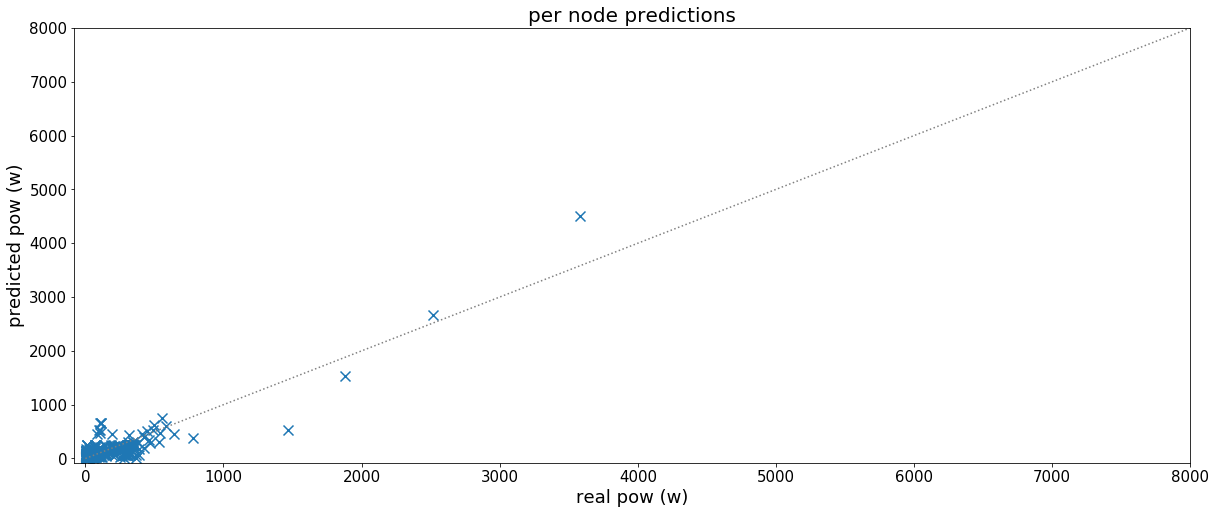

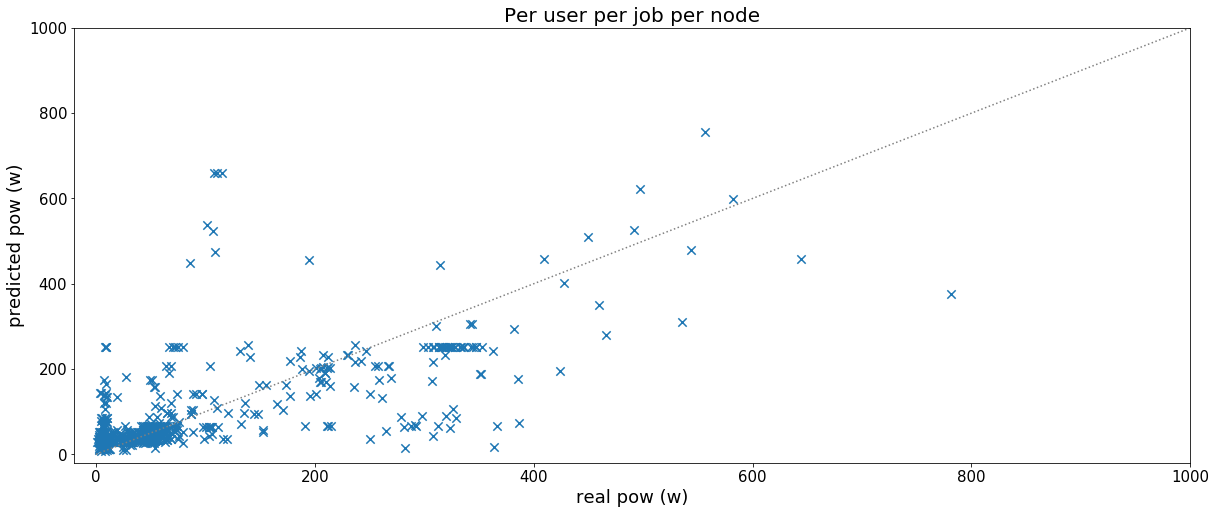

In [157]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown
my_scatter_plot(title="per node predictions", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=8000)
my_scatter_plot(title="Per user per job per node", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

In [58]:
jobs_test['pred_offline_threshold'] = jobs_predictions

In [158]:
''' 1 dictionary
Predict the power consumption of a job.
    If the user and the job name are known, than it use the method 1 [user,job,nodes]
    if only the user is known, than it use the method 2 [user,nodes]
    Otherwise it use the method 3 [nodes]
'''

def update_dict(user, job_name, used_nodes, mean_core_cons):
    
    #updaterM1 = 1
    #updaterM2 = 5
    #updaterM3 = 100
    #updaterM4 = 10
    #updaterM5 = 10
    
    #updaterM1 = 1
    #updaterM2 = 1
    ##updaterM3 = 10
    #updaterM4 = 10
    #updaterM5 = 10
    mult_perc = 0.1
    
    if(user not in dict_user_job_node): # uknown user
        dict_user_job_node[user] = {}
        dict_user_job_node[user]['user_avg'] = [0, 0]
        dict_user_job_node[user]['user_node_avg'] = {}
        
        dict_user_job_node[user][job_name] = {}
        dict_user_job_node[user][job_name]['user_job_avg'] = [0, 0] 
        
    elif(job_name not in dict_user_job_node[user]): # unknown job
        dict_user_job_node[user][job_name] = {}
        dict_user_job_node[user][job_name]['user_job_avg'] = [0, 0] 
    
    for node_id in used_nodes:
        
        # 5. per user-job-node
        if(node_id in dict_user_job_node[user][job_name]): # known node
            prev_values = dict_user_job_node[user][job_name][node_id]
            updaterM5 = prev_values[1]*mult_perc + 1
            dict_user_job_node[user][job_name][node_id][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM5) / (prev_values[1] + updaterM5)
            dict_user_job_node[user][job_name][node_id][1] = prev_values[1] + 1
        else:
            dict_user_job_node[user][job_name][node_id] = [mean_core_cons, 1] 
           
        # 3. per user-node
        if(node_id in dict_user_job_node[user]['user_node_avg']): # known node
            prev_values = dict_user_job_node[user]['user_node_avg'][node_id]
            updaterM3 = prev_values[1]*mult_perc + 1
            dict_user_job_node[user]['user_node_avg'][node_id][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM3) / (prev_values[1] + updaterM3)
            dict_user_job_node[user]['user_node_avg'][node_id][1] = prev_values[1] + 1
        else:
            dict_user_job_node[user]['user_node_avg'][node_id] = [mean_core_cons, 1] 
            
        # 1. per node
        prev_values = dict_user_job_node['node_avg'][node_id]
        updaterM1 = prev_values[1]*mult_perc + 1
        dict_user_job_node['node_avg'][node_id][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM1) / (prev_values[1] + updaterM1)
        dict_user_job_node['node_avg'][node_id][1] = prev_values[1] + 1
        
    # 4. per user-job
    prev_values = dict_user_job_node[user][job_name]['user_job_avg']
    updaterM4 = prev_values[1]*mult_perc + 1
    dict_user_job_node[user][job_name]['user_job_avg'][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM4) / (prev_values[1] + updaterM4)
    dict_user_job_node[user][job_name]['user_job_avg'][1] = prev_values[1] + 1
    
    # 2. per user
    prev_values = dict_user_job_node[user]['user_avg']
    updaterM2 = prev_values[1]*mult_perc + 1
    dict_user_job_node[user]['user_avg'][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM2) / (prev_values[1] + updaterM2)
    dict_user_job_node[user]['user_avg'][1] = prev_values[1] + 1

In [161]:
# predict online misuring the time

# ---- whole dictionary
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole"
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_clear"

with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)


#dict_user_job_node = dict(dict_user_job_node_copy)
jobs_predictions = []
global_methods_online = [0, 0, 0, 0, 0]

start_time = time.time()

for job in list_jobs_to_test:
    methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
        #used_cpus=job[3], treshold_5=0, treshold_4=0, treshold_3=0, treshold_2=0)
        used_cpus=job[3], treshold_5=4, treshold_4=4, treshold_3=4, treshold_2=4)
    #print(job)
    mean_core_cons = job[4] / sum(job[3])
    update_dict(user=job[0], job_name=job[1], used_nodes=job[2], mean_core_cons=mean_core_cons)
    
    if True:
        for j in range(5):
            global_methods_online[j] += methods[j]
    
    jobs_predictions.append(predicted_pow)
    
print("--- %s seconds ---" % (time.time() - start_time))
print(global_methods_online)
print(sum(global_methods_online))

validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

--- 0.053908586502075195 seconds ---
[475, 179, 80, 69, 13]
816
r_2 is 0.78113980040618
NRMSE is 0.9820714421354054
prediction error is 0.4942979829134968
768/768


0.78113980040618

In [162]:
df_jobs_to_test['pred_heur_online'] = jobs_predictions
df_jobs_to_test

,job_id_string,job_name,queue,start_time,run_start_time,end_time,user,node_req,cpu_req,mem_req,...,n_2_1,n_2_2,n_3_1,job_tot_timepoints,job_timepoints,good_nodes,ncores_system,njobs_system,load_system,pred_heur_online
9477,525677.node129,run_SMD,parallel,2014-04-05 12:54:38,2014-04-05 12:54:38,2014-04-05 12:54:42,szia0000,1,2,8388608,...,0,0,1,1,0,1,488,79,0,63.082851
59832,591072.node129,run71.sh,debug,2014-04-16 12:22:55,2014-04-16 12:53:08,2014-04-16 12:53:13,asaetti0,1,1,4194304,...,0,0,1,1,0,1,696,103,0,29.948538
56624,586604.node129,scriptcineca_40,parallel,2014-04-12 12:36:09,2014-04-12 15:29:14,2014-04-12 16:47:10,tbusatta,1,1,8,...,0,0,1,935,2,1,253,133,0,51.627883
50148,570438.node129,mm157-bal1.cmd,parallel,2014-04-08 08:51:02,2014-04-08 08:51:03,2014-04-08 12:51:51,rcini000,1,8,7,...,0,0,1,2889,15,1,346,28,0,241.485499
33332,590258.node129,wt_oct_131,parallel,2014-04-15 17:22:22,2014-04-15 17:23:01,2014-04-15 17:23:03,pcacciot,1,2,1048576,...,0,0,1,1,0,1,571,59,0,73.460996
69008,617136.node129,run157.sh,debug,2014-04-28 12:38:28,2014-04-28 13:11:30,2014-04-28 13:22:01,asaetti0,1,1,4194304,...,0,0,1,126,0,1,402,77,0,35.904511
25021,566030.node129,run_SMD,parallel,2014-04-07 15:43:33,2014-04-07 15:43:34,2014-04-07 15:43:36,szia0000,1,2,8388608,...,0,0,1,1,0,1,784,92,0,67.023878
1676,516363.node129,run_SMD,parallel,2014-04-05 03:38:34,2014-04-05 03:38:35,2014-04-05 03:38:37,szia0000,1,2,8388608,...,0,0,1,1,0,1,321,39,0,64.772157
37345,500394.node129,run88.sh,debug,2014-03-31 14:50:09,2014-03-31 14:51:34,2014-03-31 14:56:08,asaetti0,1,1,4,...,0,0,1,54,0,1,424,102,0,37.516333
57105,587120.node129,g.job,parallel,2014-04-13 02:37:16,2014-04-13 02:37:24,2014-04-13 03:07:35,jfranz00,1,4,4194304,...,0,1,0,362,2,1,512,94,0,97.037536


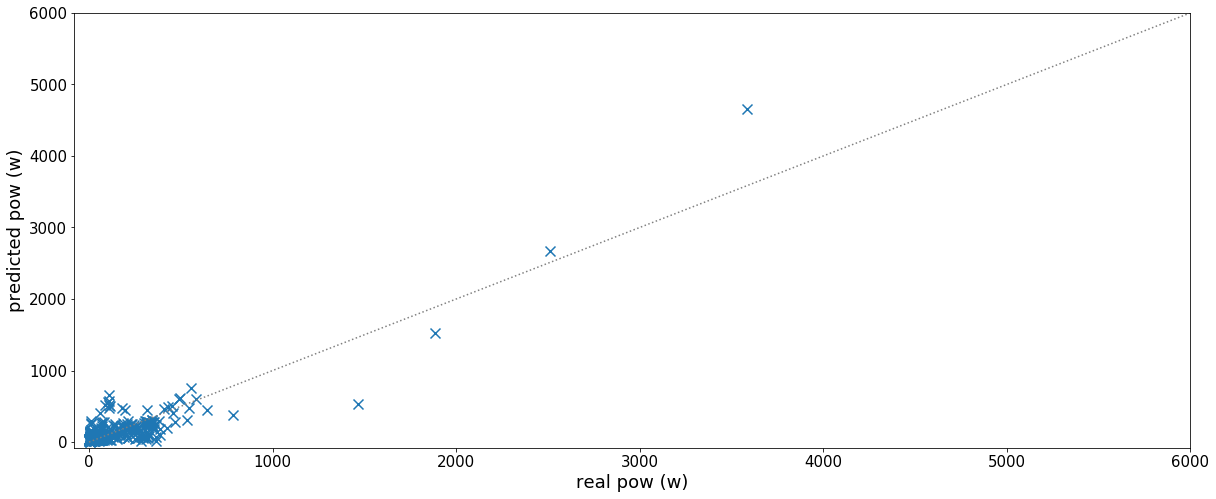

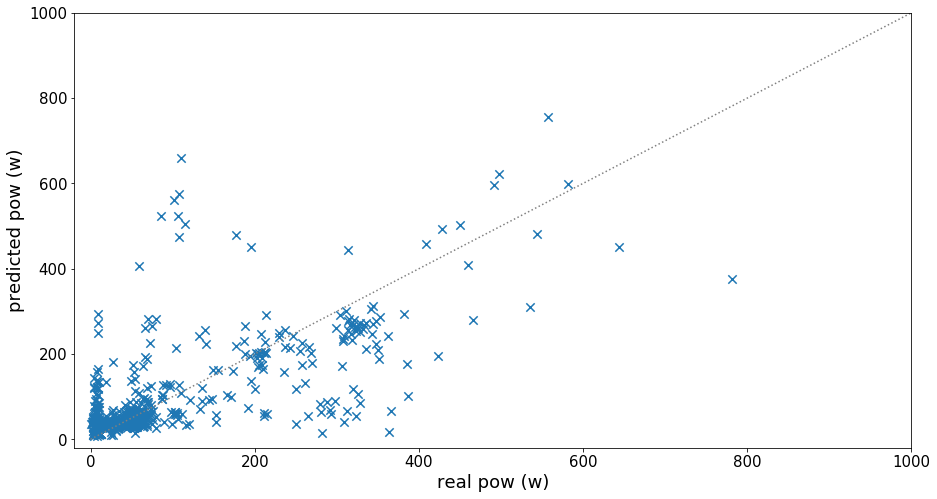

In [163]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown 100
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=6000)
my_scatter_plot_small(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

r_2 is 0.7389703178906674
NRMSE is 1.3344738301925883


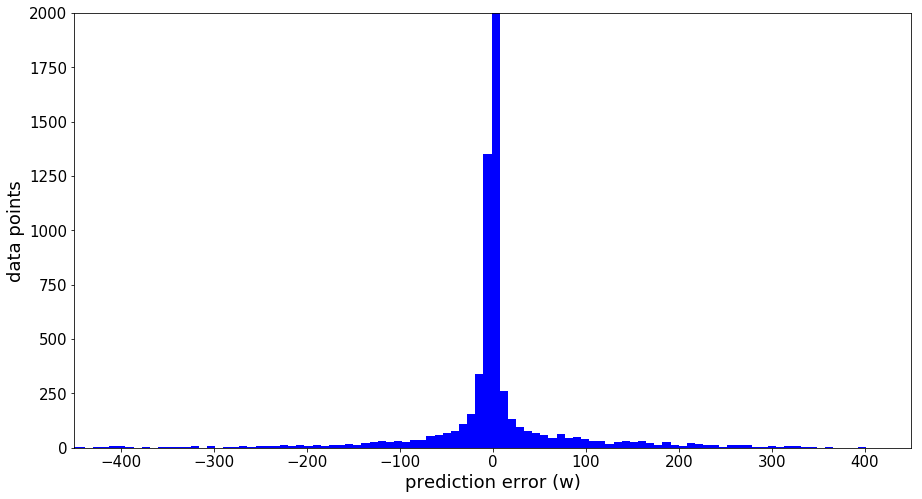

In [48]:
#Alina
#validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)
#differences = df_jobs_to_test['real_pow'] - jobs_predictions
##df = pd.DataFrame(differences)
##df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
##differences_norm = df['real_pow']
#plotPredError(differences, nbins=6000, min_x=-200, max_x=200, max_y=6000)

#Andrea
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)
differences = df_jobs_to_test['real_pow'] - jobs_predictions
#df = pd.DataFrame(differences)
#df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['real_pow']
plotPredError(differences, nbins=1000, min_x=-450, max_x=450, max_y=2000)


r_2 is 0.8227521821771369
NRMSE is 0.905608277588275


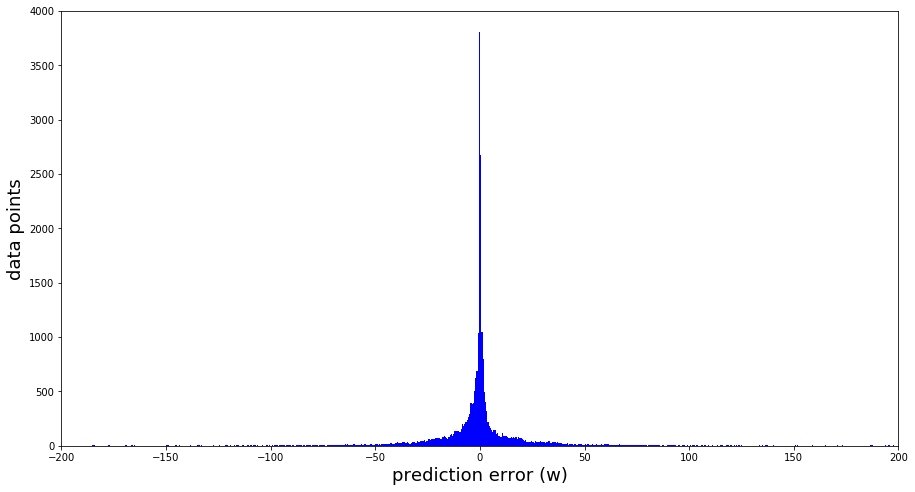

In [54]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
#df = pd.DataFrame(differences)
#df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['real_pow']
plotPredError(differences_norm, nbins=10000, min_x=-200, max_x=200, max_y=4000)



In [ ]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = (15,8)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['Total']

num_bins = 6000
n, bins, patches = plt.hist(differences, num_bins, facecolor='blue', alpha=1)
plt.axis([-150, 150, 0, 6000])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

In [ ]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = (15,8)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
differences_norm = df['real_pow']

num_bins = 6000
n, bins, patches = plt.hist(differences_norm, num_bins, facecolor='blue', alpha=1)
plt.axis([-0.02, 0.02, 0, 6000])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

In [ ]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown 100
#my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=8000)
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

In [ ]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown 1
#my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=8000)
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

In [ ]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown 10
#my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=8000)
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

In [ ]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown 40
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=8000)
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

In [90]:
jobs_test.groupby(['user', 'job_name']).size().reset_index(name='counts')

,user,job_name,counts
0,a07smr01,A2REPO,6
1,a07smr01,ARKI,8
2,a07smr01,INIT,8
3,a07smr01,LM28_OPE,8
4,a07smr01,LM7_OPE,8
5,a07smr01,LM7_TST,7
6,a07smr01,LM_PRE,10
7,a07smr01,POSTPROCESS,8
8,a07smr01,SWAN_CAM,6
9,a07smr01,SWAN_EMR,6


In [91]:
diff2 = jobs_test.assign(cpu_req=jobs_test.cpu_req.abs()).groupby(['user', 'job_name']).cpu_req.agg([('Min' , 'min'), ('Max', 'max')]).add_prefix('cpu')

In [92]:
diff = jobs_test.assign(real_pow=jobs_test.real_pow.abs()).groupby(['user', 'job_name']).real_pow.agg([('Min' , 'min'), ('Max', 'max')]).add_prefix('real')

In [93]:
diff['cpuMin'] = diff2['cpuMin'] 
diff['cpuMax'] = diff2['cpuMax'] 

In [94]:
diff

realMin      realMax  cpuMin  cpuMax
user     job_name                                                
a07smr01 A2REPO             1.853557     9.934335       1       1
         ARKI               4.031123     6.487898       1       1
         INIT               0.767963     6.569666       1       1
         LM28_OPE         598.791362  5175.382286     176     192
         LM7_OPE          591.995739  4408.091395     176     192
         LM7_TST          389.209528  3546.875791      96     192
         LM_PRE           644.951664  3824.667072     176     192
         POSTPROCESS       32.248984    51.885994       8       8
         SWAN_CAM         114.546606   798.224372      32      32
         SWAN_EMR         110.416648   669.006052      32      32
         SWAN_MAR         109.508278   730.558322      32      32
         SWAN_MED_ITA     219.456960  1425.611153      64      64
         SWAN_SIC         106.817743   749.128540      32      32
         SWAN_SNE         109.797927   725.790675      32      32
         SWAN_SUD         111.202725   731.817527      32      32
         SWAN_TOS         107.237615   790.461740      32      32
         TRANSFER1          4.031361     6.490688       1       1
         TRANSFER2          4.031361     6.490688       1       1
         WW_SWAN            4.112125    13.820870       1       1
a08tra01 my_compile_job_    3.449055    52.006522       1       1
         my_run_job_stan   36.324517    57.506912       1       1
aambrose input.job        155.933382   445.931433      16      16
aamicare AArun1            52.614676   457.592679      16      16
         AArun2            51.971128   454.565376      16      16
         AArun5            51.971128   438.756851      16      16
         AArun8            97.245154   394.520773      16      16
afarrott LPS_Q3K_0         56.639264   308.935737      16      16
afranzet Illumina.sh       71.736189    73.936867       8       8
amagnani cuidopalanwtyr.  118.314475   443.102762      16      16
         cuidopawtyrss++   71.478619   238.285192      16      16
...                              ...          ...     ...     ...
pconflit LPS_73           447.179270   447.179270      16      16
planucar STDIN              4.962434   320.321018       1       4
ppisani0 HREX_test        572.508539   572.508539      32      32
psilvest input_new.job     34.896384   779.419907       8      16
         input_short.job   29.240561   506.116633       8      16
pstipa00 E-Me-scan.cmd    468.908846   468.908846      16      16
         E-scan-TS.cmd    262.129209   262.129209      16      16
         corr.cmd         464.197466   464.197466      16      16
sachilli 0.9eV            925.393038   925.393038      32      32
         0eV              433.375032   906.035745      32      32
schen000 CoulombINB10Cij   26.313338    68.204478       1       1
scoriani job.sh            23.290089    26.534963       8       8
         jobseriale.sh     25.695710    55.857477       1       1
sdelre00 mat_par           32.823826   257.045105       8      10
sdimicco 4al0              53.241246   117.753999      16      16
         sub.sh            26.538833    26.665527       1       1
         sub_gpu.sh        26.745526    26.787982       1       1
         subcpt.sh          3.709255   186.860737       1       1
sraniolo LPS_Q3K_48       447.101611   455.621636      16      16
sschifan d2q37-avx        313.557507   313.557507      16      16
         micNOT            70.003277    70.003277      16      16
         pSoaAuto         110.408851   110.408851      16      16
         pSoaSimd         134.381752   134.381752      16      16
         prop_soa_novec   124.995467   124.995467      16      16
svitale0 debug-1.sh       447.177257   830.858012      32      32
tjones00 S1                50.355371   475.052811      16      16
         Vib              171.068786   346.173434      16      16
         xspec            115.476375   227.863555      16      16
vca

In [99]:
validate_predictions_2(diff['realMin'], diff['realMax'])

r_2 is -5.204086777594375
NRMSE is 4.638965762670424


-5.204086777594375

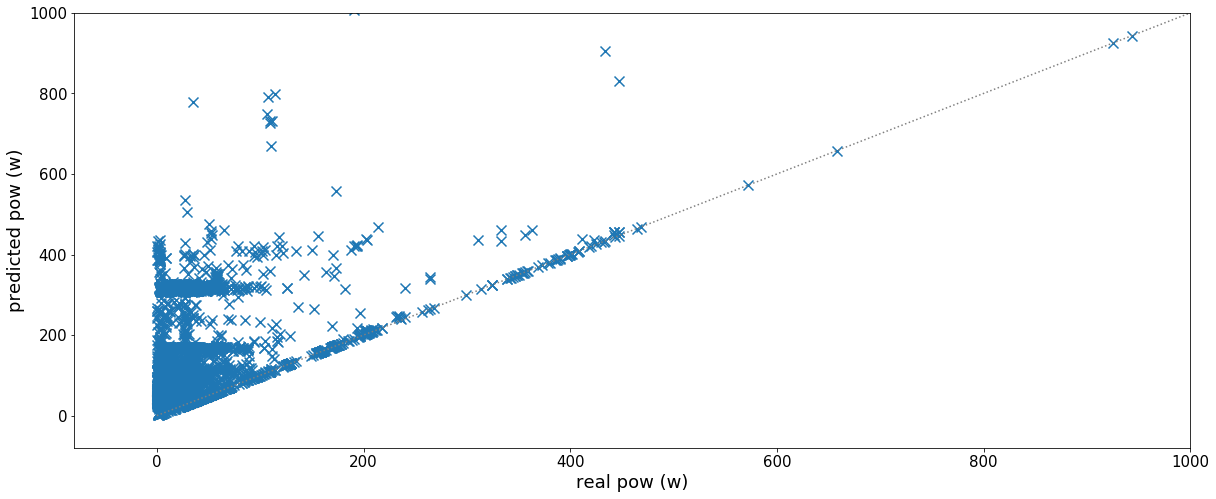

In [98]:
my_scatter_plot(title="", x_values=diff['realMin'], y_values=diff['realMax'], xy_min=-80, xy_lim=1000)

In [13]:
jobs_train = pd.read_csv(infile_jobs_trainset + ".csv", index_col=0)
print("train set contains {} records".format(jobs_train.shape[0]))
jobs_test = pd.read_csv(infile_jobs_testset + ".csv", index_col=0)
print("test set contains {} records".format(jobs_test.shape[0]))

train set contains 74240 records
test set contains 7557 records


In [15]:
data_set = pd.concat([jobs_train, jobs_test], ignore_index=True)
data_set.shape

(81797, 29)

In [17]:
ran_alone_data = data_set[data_set['ran_alone'] == True]

In [26]:
data = ran_alone_data.sample(10768)

In [27]:
train_set = data.head(10000)
test_set = data.tail(768)

(10000, 29)